In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.magnification import M, MT
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import linear, dai_yuan
from holotomocupy.chunking import gpu_batch
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import sys


%matplotlib inline

chunking.global_chunk = 10

astropy module not found
olefile module not found


In [2]:
# st = int(sys.argv[1])
st = 0
n = 2048
ntheta = 900
show = True

# ID16B setup
ndist = 4
energy = 29.63  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
detector_pixelsize= 0.65e-6
focusToDetectorDistance = 0.704433  # [m]
sx0h = 0.8525605999567023e-3; #1.077165773192669 for 75nm.
sx0v = 0.80170811624758109e-3; #1.110243284221266 for 75nm.
sx0 = 0.5*(sx0h+sx0v)
z1 = np.array([54.9598e-3, 55.96e-3, 59.1701e-3, 69.17e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
print(f"{voxelsize=}")
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//32
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/32))*32  # make multiple of 32

voxelsize=4.994972221238019e-08


In [4]:
data0 = np.zeros([ntheta,ndist,n,n],dtype='float32')
ref0 = np.zeros([1,ndist,n,n],dtype='float32')
ref1 = np.zeros([1,ndist,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')
cropx_left=cropx_right=cropy_up=cropy_down=0
binning = 0
# theta = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/angles_file.txt').astype('float32')[:][:900:900//ntheta]
# print(f'{theta=}')
for k in range(ndist):
    # for j in range(0,ntheta):
    #     # print(j)
    #     jtheta=st+j*900//ntheta
    #     fname = f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_{k+1}_/033_009_50nm_{k+1}_{jtheta:04}.edf'
    #     tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    #     for kb in range(binning):
    #         tmp = (tmp[::2]+tmp[1::2])/2
    #         tmp = (tmp[:,::2]+tmp[:,1::2])/2
    #     data0[j,k] = tmp

    tmp = dxchange.read_edf(f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    tmp1 = dxchange.read_edf(f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_{k+1}_/refHST0900.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    for kb in range(binning):
        tmp1 = (tmp1[::2]+tmp1[1::2])/2
        tmp1 = (tmp1[:,::2]+tmp1[:,1::2])/2
    ref0[:,k] = tmp
    ref1[:,k] = tmp1

tmp = dxchange.read_edf(f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_1_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
for kb in range(binning):
    tmp = (tmp[::2]+tmp[1::2])/2
    tmp = (tmp[:,::2]+tmp[:,1::2])/2
dark0[:] = tmp

# data0-=dark0
# ref0 -= dark0
# mean_all = np.mean(data0[:,:,0:n//16,0:n//16])

# mean_each = np.mean(data0[:,:,0:n//16,0:n//16],axis=(2,3))
# data0 = data0*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

# ref0_mean = np.mean(ref0[:,0:n//16,0:n//16],axis=(1,2))
# ref0 = ref0*ref0_mean/ref0_mean[:,np.newaxis,np.newaxis]

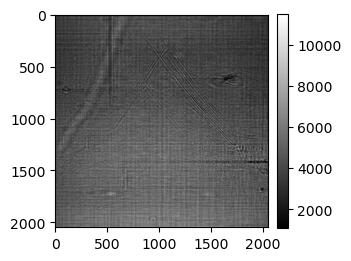

In [8]:
mshow(ref0[0,0],show)